In [87]:
import subprocess
import os
import glob
import shutil
import yaml
import argparse
import xarray as xr
import matplotlib.pyplot as plt
from functions import preproc_nemo_T
from functions import moving_average
from functions import dateDecimal
from sklearn.linear_model import LinearRegression

In [88]:
expname='giml'
leg='11'
tmp = os.path.join("/ec/res4/scratch/itas/martini", expname, leg.zfill(3))
nemo = os.path.join('/ec/res4/scratch/itas/ece4/', expname, 'output', 'nemo')

In [89]:
filelist = glob.glob(os.path.join(tmp,  expname + '*_restart.nc'))
timestep = os.path.basename(filelist[0]).split('_')[1]
oce = os.path.join(tmp, expname + '_' + timestep + '_restart.nc')
xfield = xr.open_dataset(oce)
xfield

<xarray.Dataset>
Dimensions:       (y: 148, x: 180, nav_lev: 31, time_counter: 1)
Coordinates:
  * nav_lev       (nav_lev) float32 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
  * time_counter  (time_counter) float32 5.843e+04
Dimensions without coordinates: y, x
Data variables: (12/41)
    nav_lon       (y, x) float32 ...
    nav_lat       (y, x) float32 ...
    kt            float64 ...
    ndastp        float64 ...
    adatrj        float64 ...
    ntime         float64 ...
    ...            ...
    sshn          (time_counter, y, x) float64 ...
    un            (time_counter, nav_lev, y, x) float64 ...
    vn            (time_counter, nav_lev, y, x) float64 ...
    tn            (time_counter, nav_lev, y, x) float64 ...
    sn            (time_counter, nav_lev, y, x) float64 ...
    rhop          (time_counter, nav_lev, y, x) float64 ...
Attributes:
    file_name:  /ec/res4/scratch/itas/martini/giml/011/giml_00058432_restart.nc
    TimeStamp:  06/12/2023 11:40:28 -0000

In [90]:
exp = os.path.join("/ec/res4/scratch/itas/ece4", expname)
domain = xr.open_dataset(os.path.join(exp, 'domain_cfg.nc'))
domain = domain.rename({'z': 'nav_lev'})
vol = domain['e1t']*domain['e2t']*domain['e3t_0']

In [91]:
tef = xfield['tn'].where(xfield['tn']!=0.0).isel(time_counter=0).weighted(vol).mean(dim=['nav_lev', 'y', 'x']).values

In [92]:
tef[0]

6.9514039355583686

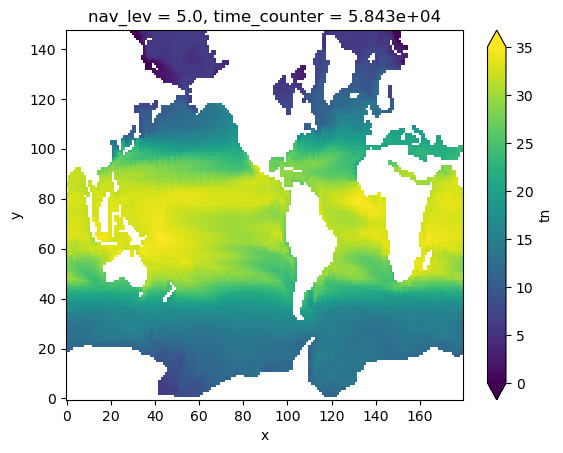

In [93]:
xfield['tn'].where(xfield['tn']!=0.0).isel(time_counter=0,nav_lev=0).plot(vmin=0, vmax=35)

In [94]:
# open database of the last chunk alone
startyear = 1995
endyear = 1999
filelist = []
for year in range(startyear, endyear):
    pattern = os.path.join(nemo, f"{expname}_oce_1m_T_{year}-{year}.nc")
    matching_files = glob.glob(pattern)
    filelist.extend(matching_files)
data = xr.open_mfdataset(filelist, preprocess=preproc_nemo_T)

In [110]:
data

<xarray.Dataset>
Dimensions:               (y: 148, x: 180, time: 48, z: 31, axis_nbounds: 2)
Coordinates:
    nav_lat_grid_T        (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    nav_lon_grid_T        (y, x) float32 dask.array<chunksize=(148, 180), meta=np.ndarray>
    time_centered         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                  (time) datetime64[ns] 1995-01-16T12:00:00 ... 1998-...
  * z                     (z) float32 -5.0 -15.0 -25.0 ... -4.75e+03 -5.25e+03
Dimensions without coordinates: y, x, axis_nbounds
Data variables: (12/25)
    deptht_bounds         (time, z, axis_nbounds) float32 dask.array<chunksize=(12, 31, 2), meta=np.ndarray>
    time_centered_bounds  (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    e3t                   (time, z, y, x) float32 dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    thetao                (time, z, y, x) float32 dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    so                    (time, z, y, x) float32 dask.array<chunksize=(1, 31, 148, 180), meta=np.ndarray>
    ...                    ...
    qt_oce                (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    sfx                   (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    taum                  (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    windsp                (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    precip                (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
    snowpre               (time, y, x) float32 dask.array<chunksize=(1, 148, 180), meta=np.ndarray>
Attributes:
    name:         output/nemo/giml_oce_1m_T
    description:  ECE4/NEMO T grid variables
    title:        ECE4/NEMO T grid variables
    Conventions:  CF-1.6
    timeStamp:    2023-Dec-07 11:27:12 GMT
    uuid:         4ef34960-d79d-46d9-9110-1f999716c82c

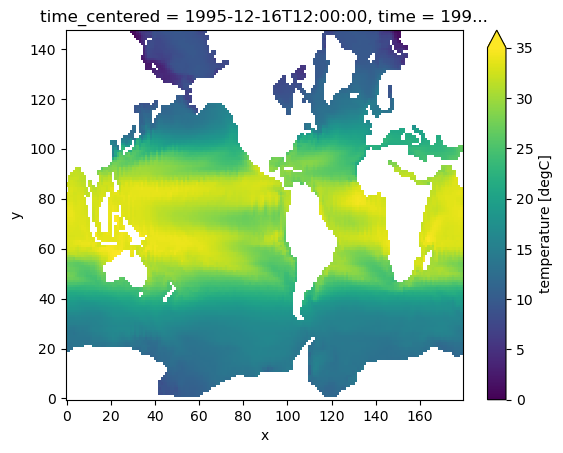

In [95]:
data['thetao'].isel(time=11,z=0).plot(vmin=0, vmax=35)

In [96]:
domain = xr.open_dataset(os.path.join(exp, 'domain_cfg.nc'))
vol = domain['e1t']*domain['e2t']*domain['e3t_0']
tem = data['thetao'].isel(time=11).weighted(vol).mean(dim=['z', 'y', 'x']).values

In [100]:
area = domain['e1t']*domain['e2t']

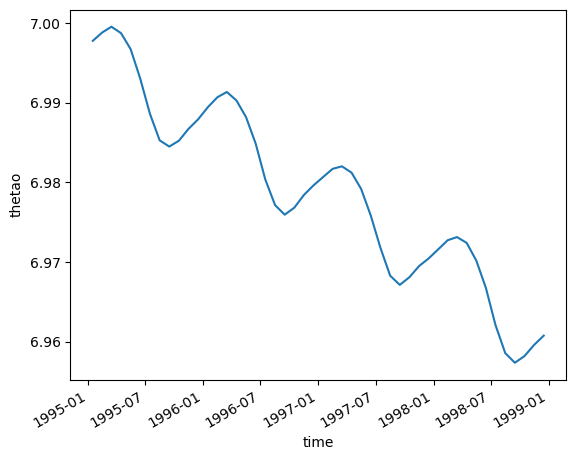

In [97]:
data['thetao'].weighted(vol).mean(dim=['z', 'y', 'x']).plot()

In [98]:
tt = dateDecimal(data['time'].values)
toa = data['thetao'].weighted(vol).mean(dim=['z', 'y', 'x']).values.flatten()
tom = moving_average(toa, 12)

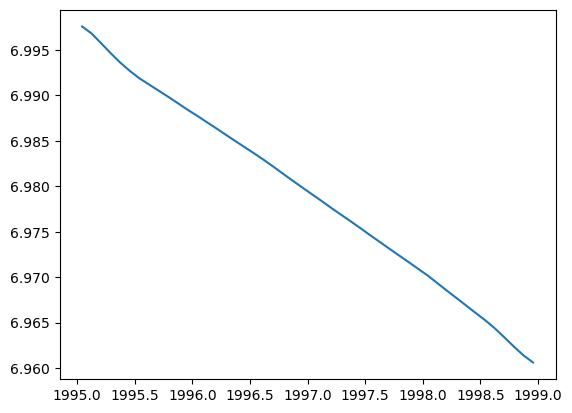

In [99]:
plt.plot(tt,tom)

In [122]:
data['thetao'].isel(z=0,time=0).mean(dim=['y', 'x']).values

array(22.665014, dtype=float32)

In [ ]:
yearleap = 10
Yg = [[tom[i]] for i in range(len(tom))]
Xg = [[tt[i]] for i in range(len(tt))]
model=LinearRegression()
model.fit(Xg, Yg)
mp = model.coef_[0][0]
qp = model.intercept_[0]
teq = mp*(endyear+yearleap) + qp
print(' Fit coefficients: ',mp,qp)
print(' Projected Temperature: ',teq)

In [ ]:
trel = teq/tef[0]
yfield = {}
yfield['tn'] = xfield['tn']
yfield['tn'] = xr.where(xfield['tn']!=0, (1.0-trel)*xfield['tn'], (1.0+trel)*xfield['tn'])

In [ ]:
yfield['tn'].where(yfield['tn']!=0.0).isel(time_counter=0,nav_lev=0).plot(vmin=0, vmax=35)